In [24]:
df_test = pd.read_parquet('submission_data.parquet')
#df_test[(df_test['country'] == 'Themyscira')& (df_test['brand'] == 'AITPJ')]
unique_combinations = df_test[['country', 'brand']].drop_duplicates()
unique_combinations.reset_index(drop=True, inplace=True)

In [146]:
df_test

,country,brand,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,main_channel
5356,Aldovia,AIMST,0.0,1.0,0.047619,NaN,NaN,2.0,0.0,5,4,4,4,4,2022-01-03,1,20,NaN
5357,Aldovia,AIMST,1.0,1.0,0.095238,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-04,2,19,NaN
5358,Aldovia,AIMST,2.0,1.0,0.142857,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-05,3,18,NaN
5359,Aldovia,AIMST,3.0,1.0,0.190476,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-06,4,17,NaN
5360,Aldovia,AIMST,4.0,1.0,0.238095,NaN,NaN,0.0,2.0,5,4,4,4,4,2022-01-07,5,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11918,Zamunda,ZKKLD,0.0,12.0,0.733333,R,0.00088,2.0,0.0,3,3,3,2,4,2022-12-19,11,4,RETAIL
11919,Zamunda,ZKKLD,1.0,12.0,0.800000,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-20,12,3,RETAIL
11920,Zamunda,ZKKLD,2.0,12.0,0.866667,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-21,13,2,RETAIL
11921,Zamunda,ZKKLD,3.0,12.0,0.933333,R,0.00088,0.0,0.0,3,3,3,2,4,2022-12-22,14,1,RETAIL


In [23]:
unique_combinations['brand'][0]

'AIMST'

In [492]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

class TimeSeriesLSTM:
    def __init__(self, data_path, test_data_path=None):
        self.train_df = pd.read_parquet(data_path)
        self.test_df = pd.read_parquet(test_data_path) if test_data_path else None
        self.model = None
    
    def get_unique_combinations(self, df_test):
        unique_combinations = df_test[['country', 'brand']].drop_duplicates()
        unique_combinations.reset_index(drop=True, inplace=True)
        return unique_combinations
    
    def preprocess_data(self, dataset_type='train', country='Themyscira', brand='EUJWP', features=None):
        if dataset_type == 'train':
            df = self.train_df
        elif dataset_type == 'test':
            df = self.test_df
        else:
            raise ValueError("Invalid dataset type specified. Choose 'train' or 'test'.")
        

        df_filtered = df[(df['country'] == country) & (df['brand'] == brand)]
        print(df_filtered)
        #df_filtered.set_index('date', inplace=True)
        #df_filtered.reset_index(drop=True, inplace=True)
        

        # Ensure 'date' is a column and set it as the index
        if 'date' in df_filtered.columns:
            df_filtered.set_index('date', inplace=True)
            datetime_indices = df_filtered.index  # Get the datetime indices from the DataFrame
        else:
            raise ValueError("Date column not found in DataFrame")
        print(datetime_indices)
        # Select specified features if provided
        if features:
            #Scaling
            scaler = MinMaxScaler()
            feature_transform = scaler.fit_transform(df_filtered[features]) 
            if dataset_type == "train":
                feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=datetime_indices)
                #df[(df['country']==country) & (df['brand']==brand)].index
            #df_filtered = df_filtered[features]
        # Optionally, handle the case where features are not specified
        if 'phase' in df_filtered.columns:
            output_var = df_filtered['phase']
            return feature_transform, output_var
        else:
            return feature_transform, datetime_indices

    def split_data(self, feature_transform, output_var, split_ratio=0.8):
        split_index = int(len(feature_transform) * split_ratio)
        X_train, X_val = feature_transform.iloc[:split_index], feature_transform.iloc[split_index:]
        y_train, y_val = output_var.iloc[:split_index], output_var.iloc[split_index:]
        #X_train, X_val, y_train, y_val = train_test_split(feature_transform, output_var, test_size=0.2, shuffle=False)
        return X_train, X_val, y_train, y_val

    def preprocess_for_lstm(self, X):
        X = np.array(X)
        X = X.reshape(X.shape[0], 1, X.shape[1])
        return X

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(LSTM(32, input_shape=input_shape, activation="relu", return_sequences=False))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='relu'))
        self.model.compile(loss="mean_squared_error", optimizer="adam")


    def train(self, X_train, y_train, X_val, y_val, epochs=20, verbose=1, batch_size=8):
        # Training will halt if the validation loss fails to improve for 50 consecutive epochs, and the model will revert to the state where it had the best validation loss.
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        return self.model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size, verbose=1, shuffle=False, callbacks=[early_stopping])

    def plot_loss(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def predict_plot(self, y_pred):
        plt.plot(y_pred, label="LSTM Prediction")
        plt.title("Prediction by LSTM")
        plt.xlabel("Time Scale")
        plt.ylabel("Scaled USD")
        plt.legend()
        plt.show()

    def phase_normalized(self, predictions):
        # Group by month and normalize
        predictions['month'] = predictions['date'].dt.to_period('M')
        grouped = predictions.groupby('month')

        normalized_predictions = []

        for name, group in grouped:
            month_sum = group['predictions'].sum()
            group['normalized_prediction'] = group['predictions'] / month_sum
            normalized_predictions.append(group)

        # Concatenate results
        final_predictions = pd.concat(normalized_predictions)
        return final_predictions


In [493]:
df_submission = pd.read_csv("submission_template.csv")
df_submission['date'] = pd.to_datetime(df_submission['date'])
# Usage Example
train_data_path = 'train_data.parquet'
test_data_path = 'submission_data.parquet'

ts_lstm = TimeSeriesLSTM(train_data_path, test_data_path) # Initialize the class
# Get unique country-brand combinations
unique_combinations = ts_lstm.get_unique_combinations(df_test)

#Selecting the Features
features = ['dayweek', 'month', 'wd_perc', 'n_nwd_bef', 'n_nwd_aft', 'wd', 'wd_left'] #removed monthly feature for now since we ca't use it for the publiuca dataset production

all_predictions = []

for index, row in unique_combinations.iterrows():
    country = row['country']
    brand = row['brand']

    # Preprocess Training Data
    feature_transform, output_var = ts_lstm.preprocess_data(dataset_type="train", country=country, brand=brand, features=features)
    X_train, X_val, y_train, y_val = ts_lstm.split_data(feature_transform, output_var)
    X_train = ts_lstm.preprocess_for_lstm(X_train)
    X_val = ts_lstm.preprocess_for_lstm(X_val)

    # Build, Train, and Plot Model Loss
    lstm = ts_lstm.build_model(input_shape=X_train.shape[1:])
    history = ts_lstm.train(X_train, y_train, X_val, y_val, epochs=5, batch_size=8)
    ts_lstm.plot_loss(history)

    # Preprocess Test Data
    X_test, datetime_indices = ts_lstm.preprocess_data(dataset_type="test", country=country, brand=brand, features=features)
    X_test = ts_lstm.preprocess_for_lstm(X_test)

    # Make Predictions
    predictions = ts_lstm.predict(X_test)
    ts_lstm.predict_plot(predictions)

    # Post-process and Normalize Predictions
    if len(predictions.flatten()) == len(X_test):
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
        X_test = pd.DataFrame(columns=features, data=X_test, index=datetime_indices) 
        X_test['predictions'] = predictions.flatten()
        X_test = X_test.reset_index().rename(columns={'index': 'date'})
        X_test = ts_lstm.phase_normalized(X_test)
        X_test['country'] = country
        X_test['brand'] = brand

        all_predictions.append(X_test)
        print(X_test)
    else:
        raise ValueError("Mismatch in the number of predictions and the number of rows in the feature_transform DataFrame.")

# Combine all predictions
combined_predictions = pd.concat(all_predictions)

# Merge with the submission file
df_submission = df_submission.merge(combined_predictions[['country', 'brand', 'date', 'normalized_prediction']],
                                    on=['country', 'brand', 'date'],
                                    how='left')


      brand     phase  country  dayweek  month   wd_perc ther_area   
0     AIMST  0.006284  Aldovia      2.0    1.0  0.045455       NaN  \
1     AIMST  0.123459  Aldovia      3.0    1.0  0.090909       NaN   
2     AIMST  0.055607  Aldovia      4.0    1.0  0.136364       NaN   
3     AIMST  0.032148  Aldovia      0.0    1.0  0.181818       NaN   
4     AIMST  0.097054  Aldovia      1.0    1.0  0.227273       NaN   
...     ...       ...      ...      ...    ...       ...       ...   
2037  AIMST  0.029592  Aldovia      0.0   12.0  0.809524       NaN   
2038  AIMST  0.042513  Aldovia      1.0   12.0  0.857143       NaN   
2039  AIMST  0.011557  Aldovia      2.0   12.0  0.904762       NaN   
2040  AIMST  0.000000  Aldovia      3.0   12.0  0.952381       NaN   
2041  AIMST  0.000000  Aldovia      4.0   12.0  1.000000       NaN   

      hospital_rate  n_nwd_bef  n_nwd_aft  n_weekday_0  n_weekday_1   
0               NaN        4.0        0.0            4            4  \
1               N

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x32xi1>'


203/205 [============================>.] - ETA: 0s - loss: 0.0016

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x32xi1>'


205/205 [==============================] - 6s 26ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/5
205/205 [==============================] - 4s 20ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/5
205/205 [==============================] - 4s 20ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/5
204/205 [============================>.] - ETA: 0s - loss: 0.0014

KeyboardInterrupt: 

So I have to save the date from the index in a new variable and then merge it the main submission file by date, species and brand

In [468]:
# Usage Example
train_data_path = 'train_data.parquet'
test_data_path = 'submission_data.parquet'

ts_lstm = TimeSeriesLSTM(train_data_path, test_data_path) # Initialize the class
#df_test = pd.read_parquet(test_data_path)

# Get unique country-brand combinations
unique_combinations = ts_lstm.get_unique_combinations(df_test)

#Selecting the Features
features = ['dayweek', 'month', 'wd_perc', 'n_nwd_bef', 'n_nwd_aft', 'wd', 'wd_left'] #removed monthly feature for now since we ca't use it for the publiuca dataset production

# Preprocess Data for the first country-brand combination
#country = unique_combinations['country'][0]
#brand = unique_combinations['brand'][0]
country = "Aldovia"
brand = "EUJWP"
feature_transform, output_var = ts_lstm.preprocess_data(dataset_type="train", country=country, brand=brand, features=features)
print(unique_combinations)



       brand     phase  country  dayweek  month   wd_perc ther_area   
25724  EUJWP  0.000000  Aldovia      2.0    1.0  0.045455         A  \
25725  EUJWP  0.118772  Aldovia      3.0    1.0  0.090909         A   
25726  EUJWP  0.119078  Aldovia      4.0    1.0  0.136364         A   
25727  EUJWP  0.018851  Aldovia      0.0    1.0  0.181818         A   
25728  EUJWP  0.085774  Aldovia      1.0    1.0  0.227273         A   
...      ...       ...      ...      ...    ...       ...       ...   
27740  EUJWP  0.000019  Aldovia      0.0   12.0  0.809524         A   
27741  EUJWP  0.030278  Aldovia      1.0   12.0  0.857143         A   
27742  EUJWP  0.000000  Aldovia      2.0   12.0  0.904762         A   
27743  EUJWP  0.000000  Aldovia      3.0   12.0  0.952381         A   
27744  EUJWP  0.000000  Aldovia      4.0   12.0  1.000000         A   

       hospital_rate  n_nwd_bef  n_nwd_aft  n_weekday_0  n_weekday_1   
25724       0.000385        4.0        0.0            4            4  \
257

In [469]:
feature_transform

,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left
date,,,,,,,
2013-01-02,0.50,0.0,0.002066,0.363636,0.000000,0.000000,0.954545
2013-01-03,0.75,0.0,0.049587,0.000000,0.000000,0.045455,0.909091
2013-01-04,1.00,0.0,0.097107,0.000000,0.181818,0.090909,0.863636
2013-01-07,0.00,0.0,0.144628,0.181818,0.000000,0.136364,0.818182
2013-01-08,0.25,0.0,0.192149,0.000000,0.000000,0.181818,0.772727
...,...,...,...,...,...,...,...
2021-12-27,0.00,1.0,0.800866,0.181818,0.000000,0.727273,0.181818
2021-12-28,0.25,1.0,0.850649,0.000000,0.000000,0.772727,0.136364
2021-12-29,0.50,1.0,0.900433,0.000000,0.000000,0.818182,0.090909


In [470]:
output_var

date
2013-01-02    0.000000
2013-01-03    0.118772
2013-01-04    0.119078
2013-01-07    0.018851
2013-01-08    0.085774
                ...   
2021-12-27    0.000019
2021-12-28    0.030278
2021-12-29    0.000000
2021-12-30    0.000000
2021-12-31    0.000000
Name: phase, Length: 2021, dtype: float64

# Model

In [471]:
X_train, X_val, y_train, y_val = ts_lstm.split_data(feature_transform, output_var)
X_train = ts_lstm.preprocess_for_lstm(X_train)
X_val = ts_lstm.preprocess_for_lstm(X_val)

In [472]:
lstm = ts_lstm.build_model(input_shape=X_train.shape[1:])

In [473]:
history = ts_lstm.train(X_train, y_train, X_val, y_val, epochs=5, batch_size=8)

Epoch 1/5


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x32xi1>'


202/202 [==============================] - 5s 20ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 2/5
202/202 [==============================] - 3s 15ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/5
202/202 [==============================] - 3s 15ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/5
202/202 [==============================] - 3s 16ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/5
202/202 [==============================] - 3s 15ms/step - loss: 0.0020 - val_loss: 0.0016


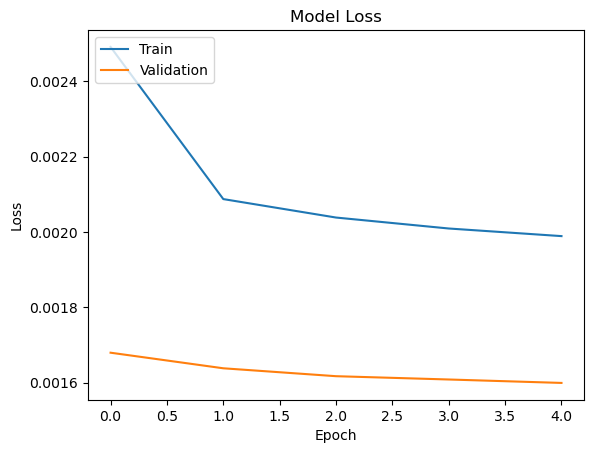

In [474]:
ts_lstm.plot_loss(history)

# Prediction
Now, that we have our model, we will make predictions

In [475]:
# Step 2: Preprocess the test data
X_test, datetime_indices= ts_lstm.preprocess_data(dataset_type="test",country=country, brand=brand, features=features)

       country  brand  dayweek  month   wd_perc ther_area  hospital_rate   
69295  Aldovia  EUJWP      0.0    1.0  0.047619         A       0.000385  \
69296  Aldovia  EUJWP      1.0    1.0  0.095238         A       0.000385   
69297  Aldovia  EUJWP      2.0    1.0  0.142857         A       0.000385   
69298  Aldovia  EUJWP      3.0    1.0  0.190476         A       0.000385   
69299  Aldovia  EUJWP      4.0    1.0  0.238095         A       0.000385   
...        ...    ...      ...    ...       ...       ...            ...   
69537  Aldovia  EUJWP      0.0   12.0  0.764706         A       0.000385   
69538  Aldovia  EUJWP      1.0   12.0  0.823529         A       0.000385   
69539  Aldovia  EUJWP      2.0   12.0  0.882353         A       0.000385   
69540  Aldovia  EUJWP      3.0   12.0  0.941176         A       0.000385   
69541  Aldovia  EUJWP      4.0   12.0  1.000000         A       0.000385   

       n_nwd_bef  n_nwd_aft  n_weekday_0  n_weekday_1  n_weekday_2   
69295        2.0 

In [476]:
X_test.shape

(247, 7)

In [477]:
datetime_indices

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23'],
              dtype='datetime64[us]', name='date', length=247, freq=None)

In [478]:
len(X_test)

247

In [479]:
X_test.shape

(247, 7)

In [480]:
# Step 3: Reshape the test data for LSTM
X_test = ts_lstm.preprocess_for_lstm(X_test)
# Step 4: Make predictions
predictions = ts_lstm.predict(X_test)

# Optionally, post-process predictions (e.g., normalization)
# ... Additional processing ...

8/8 [==============================] - 0s 30ms/step


In [481]:
#flatten to match the shape of the test data
predictions.flatten()

array([0.03974243, 0.06305389, 0.06029959, 0.04629072, 0.03690783,
       0.05591553, 0.06909117, 0.05652813, 0.04189553, 0.03266385,
       0.05579706, 0.05544668, 0.04169184, 0.02926941, 0.02076628,
       0.04527698, 0.04211535, 0.02938333, 0.01550914, 0.00492419,
       0.03249314, 0.06022102, 0.05870615, 0.04573873, 0.03633871,
       0.05062188, 0.06941289, 0.05589299, 0.04133207, 0.03207475,
       0.05599499, 0.05604501, 0.042363  , 0.02837012, 0.02029861,
       0.0442497 , 0.04167332, 0.02894384, 0.01507968, 0.00469933,
       0.03114029, 0.06061923, 0.05936229, 0.05111195, 0.04147185,
       0.03621292, 0.06116053, 0.04564665, 0.03673758, 0.05808536,
       0.0643421 , 0.05055267, 0.03533305, 0.02601762, 0.0498652 ,
       0.04998756, 0.03567963, 0.02179937, 0.01133459, 0.03721272,
       0.03439024, 0.02105066, 0.00649555, 0.03534983, 0.04002249,
       0.0658609 , 0.05896898, 0.04152617, 0.03279736, 0.0533709 ,
       0.06078034, 0.06138304, 0.0407595 , 0.04021192, 0.02532

In [482]:
len(X_test)

247

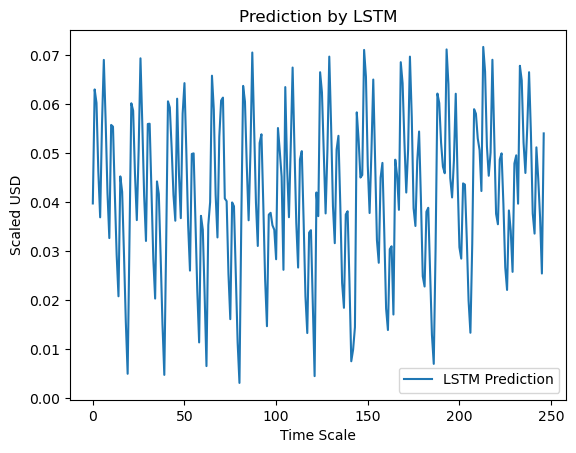

In [483]:
# Plot or analyze predictions
ts_lstm.predict_plot(predictions)

In [484]:
# Adding predictions to the DataFrame
if len(predictions.flatten()) == len(X_test):
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
    X_test = pd.DataFrame(columns=features, data=X_test, index=datetime_indices) 
    X_test['predictions'] = predictions.flatten()
else:
    raise ValueError("Mismatch in the number of predictions and the number of rows in the feature_transform DataFrame.")

In [485]:
X_test = X_test.reset_index().rename(columns={'index': 'date'})
X_test


,date,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left,predictions
0,2022-01-03,0.00,0.0,0.002268,0.4,0.0,0.000000,0.952381,0.039742
1,2022-01-04,0.25,0.0,0.052154,0.0,0.0,0.047619,0.904762,0.063054
2,2022-01-05,0.50,0.0,0.102041,0.0,0.0,0.095238,0.857143,0.060300
3,2022-01-06,0.75,0.0,0.151927,0.0,0.0,0.142857,0.809524,0.046291
4,2022-01-07,1.00,0.0,0.201814,0.0,0.2,0.190476,0.761905,0.036908
...,...,...,...,...,...,...,...,...,...
242,2022-12-19,0.00,1.0,0.753501,0.4,0.0,0.571429,0.190476,0.051213
243,2022-12-20,0.25,1.0,0.815126,0.0,0.0,0.619048,0.142857,0.044803
244,2022-12-21,0.50,1.0,0.876751,0.0,0.0,0.666667,0.095238,0.036884
245,2022-12-22,0.75,1.0,0.938375,0.0,0.0,0.714286,0.047619,0.025419


In [486]:
# Step 5: Post-process predictions
X_test=ts_lstm.phase_normalized(X_test)
X_test

,date,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left,predictions,normalized_prediction
0,2022-01-03,0.00,2022-01,0.002268,0.4,0.0,0.000000,0.952381,0.039742,0.045417
1,2022-01-04,0.25,2022-01,0.052154,0.0,0.0,0.047619,0.904762,0.063054,0.072056
2,2022-01-05,0.50,2022-01,0.102041,0.0,0.0,0.095238,0.857143,0.060300,0.068909
3,2022-01-06,0.75,2022-01,0.151927,0.0,0.0,0.142857,0.809524,0.046291,0.052900
4,2022-01-07,1.00,2022-01,0.201814,0.0,0.2,0.190476,0.761905,0.036908,0.042177
...,...,...,...,...,...,...,...,...,...,...
242,2022-12-19,0.00,2022-12,0.753501,0.4,0.0,0.571429,0.190476,0.051213,0.061868
243,2022-12-20,0.25,2022-12,0.815126,0.0,0.0,0.619048,0.142857,0.044803,0.054124
244,2022-12-21,0.50,2022-12,0.876751,0.0,0.0,0.666667,0.095238,0.036884,0.044558
245,2022-12-22,0.75,2022-12,0.938375,0.0,0.0,0.714286,0.047619,0.025419,0.030708


In [487]:
X_test['country'] = country
X_test['brand'] = brand
X_test

,date,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left,predictions,normalized_prediction,country,brand
0,2022-01-03,0.00,2022-01,0.002268,0.4,0.0,0.000000,0.952381,0.039742,0.045417,Aldovia,EUJWP
1,2022-01-04,0.25,2022-01,0.052154,0.0,0.0,0.047619,0.904762,0.063054,0.072056,Aldovia,EUJWP
2,2022-01-05,0.50,2022-01,0.102041,0.0,0.0,0.095238,0.857143,0.060300,0.068909,Aldovia,EUJWP
3,2022-01-06,0.75,2022-01,0.151927,0.0,0.0,0.142857,0.809524,0.046291,0.052900,Aldovia,EUJWP
4,2022-01-07,1.00,2022-01,0.201814,0.0,0.2,0.190476,0.761905,0.036908,0.042177,Aldovia,EUJWP
...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-12-19,0.00,2022-12,0.753501,0.4,0.0,0.571429,0.190476,0.051213,0.061868,Aldovia,EUJWP
243,2022-12-20,0.25,2022-12,0.815126,0.0,0.0,0.619048,0.142857,0.044803,0.054124,Aldovia,EUJWP
244,2022-12-21,0.50,2022-12,0.876751,0.0,0.0,0.666667,0.095238,0.036884,0.044558,Aldovia,EUJWP
245,2022-12-22,0.75,2022-12,0.938375,0.0,0.0,0.714286,0.047619,0.025419,0.030708,Aldovia,EUJWP


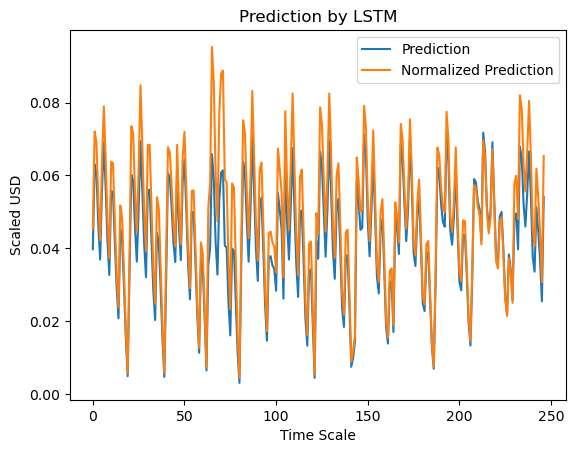

In [488]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(X_test['predictions'], label="Prediction")
plt.plot(X_test['normalized_prediction'], label="Normalized Prediction")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [489]:
df_submission = pd.read_csv("submission_template.csv")
df_submission

,country,brand,date,prediction
0,Aldovia,AIMST,2022-01-03,NaN
1,Aldovia,AIMST,2022-01-04,NaN
2,Aldovia,AIMST,2022-01-05,NaN
3,Aldovia,AIMST,2022-01-06,NaN
4,Aldovia,AIMST,2022-01-07,NaN
...,...,...,...,...
180840,Zamunda,ZKKLD,2022-12-19,NaN
180841,Zamunda,ZKKLD,2022-12-20,NaN
180842,Zamunda,ZKKLD,2022-12-21,NaN
180843,Zamunda,ZKKLD,2022-12-22,NaN


In [490]:
df_submission.info()
df_submission['date'] = pd.to_datetime(df_submission['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180845 entries, 0 to 180844
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   country     180845 non-null  object 
 1   brand       180845 non-null  object 
 2   date        180845 non-null  object 
 3   prediction  0 non-null       float64
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


In [491]:
df_submission.merge(X_test[['country', 'brand', 'date', 'normalized_prediction']],
                                    on=['country', 'brand', 'date'],
                                    how='left')

,country,brand,date,prediction,normalized_prediction
0,Aldovia,AIMST,2022-01-03 00:00:00,NaN,NaN
1,Aldovia,AIMST,2022-01-04 00:00:00,NaN,NaN
2,Aldovia,AIMST,2022-01-05 00:00:00,NaN,NaN
3,Aldovia,AIMST,2022-01-06 00:00:00,NaN,NaN
4,Aldovia,AIMST,2022-01-07 00:00:00,NaN,NaN
...,...,...,...,...,...
180840,Zamunda,ZKKLD,2022-12-19 00:00:00,NaN,NaN
180841,Zamunda,ZKKLD,2022-12-20 00:00:00,NaN,NaN
180842,Zamunda,ZKKLD,2022-12-21 00:00:00,NaN,NaN
180843,Zamunda,ZKKLD,2022-12-22 00:00:00,NaN,NaN
